<a href="https://colab.research.google.com/github/harishkollana/Topic-Modeling-on-News-Articles-Clustering/blob/main/Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [54]:
#import libraries for topic modeling on news articles
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import glob
import string
import nltk
nltk.download('omw-1.4')

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
!pip install spacy
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [56]:
!pip install pyLDAvis==3.2.1

In [57]:
!pip install -U pandas-profiling

Import Data

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
#load path to data
path = '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc'

In [60]:
#Importing text file paths
business = glob.glob(path+'/business/*')
entertainment = glob.glob(path+'/entertainment/*')
politics = glob.glob(path+'/politics/*')
sports = glob.glob(path+'/sport/*')
tech = glob.glob(path+'/tech/*')

In [61]:
business[0:5]

['/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/507.txt',
 '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/505.txt',
 '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/471.txt',
 '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/498.txt',
 '/content/drive/MyDrive/Capstone Projects/Topic Modeling on News Articles/bbc/business/510.txt']

In [62]:
# Making the data lists for different topics.
def make_list(data):
    list = []
    for i in range(len(data)):
      file = open(data[i],'r')
      list.append(file.read())
    return(list)

In [63]:
sports_text=[]

for i in range(len(sports)):
  f=open(sports[i],errors='ignore')
  a=f.read()
  sports_text.append(a)

In [64]:
sports_text[0]

'Henman to face Saulnier test\n\nBritish number one Tim Henman will face France\'s Cyril Saulnier in the first round of next week\'s Australian Open.\n\nGreg Rusedski, the British number two, is in the same quarter of the draw and could face Andy Roddick in the second round if he beats Swede Jonas Bjorkman. Local favourite Lleyton Hewitt will meet France\'s Arnaud Clement, while defending champion and world number one Roger Federer faces Fabrice Santoro. Women\'s top seed Lindsay Davenport drew Spanish veteran Conchita Martinez.\n\nHenman came from two sets down to defeat Saulnier in the first round of the French Open last year, so he knows he faces a tough test in Melbourne. The seventh seed, who has never gone beyond the quarter-finals in the year\'s first major and is lined up to meet Roddick in the last eight, is looking forward to the match. "He\'s tough player on any surface, he\'s got a lot of ability," he said. "We had a really tight one in Paris that went my way so I\'m going 

In [65]:
business_texts= make_list(business)
entertainment_text = make_list(entertainment)
politics_texts= make_list(politics)
tech_text = make_list(tech)

In [66]:
#Number of documents in every topics
print(len(business_texts),len(entertainment_text),len(politics_texts),len(sports_text),len(tech_text))

510 386 417 511 401


In [67]:
# Combine the topics.
complete_text = business_texts + entertainment_text + politics_texts + sports_text + tech_text

In [68]:
len(complete_text)

2225

From the above we can see that, the length of the complete text is 2225.

In [69]:
# Make the dataframe of texts.
df = pd.DataFrame({'text': complete_text, 'type': ['business']*len(business_texts) + ['entertainment']*len(entertainment_text) + ['politics']*len(politics_texts) + ['sport']*len(sports_text) + ['tech']*len(tech_text)})

Data Cleaning

In [70]:
df.head()

,text,type
0,UK economy ends year with spurt\n\nThe UK econ...,business
1,China now top trader with Japan\n\nChina overt...,business
2,Tsunami slows Sri Lanka's growth\n\nSri Lanka'...,business
3,Millions go missing at China bank\n\nTwo senio...,business
4,Lacroix label bought by US firm\n\nLuxury good...,business


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
 1   type    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [72]:
# removing duplicate observations
df=df.drop_duplicates()

In [73]:
# Removal of "\n"
# Converting the words to the lowercase.
# Removal of stopword.

def text_processing(data):
  data = data.map(lambda x: x.replace('\n',' '))
  data = data.map(lambda x: x.lower())
  #data = data.map(lambda x: ''.join([i for i in x if i not in string.punctuation]))
  data = data.map(lambda x: ' '.join([i for i in x.split(' ') if i not in stopwords.words('english')]))
  return data

In [74]:
# Converting column into astring
df['text'] = df['text'].astype('str') 

In [75]:
#check data
df.head()

,text,type
0,UK economy ends year with spurt\n\nThe UK econ...,business
1,China now top trader with Japan\n\nChina overt...,business
2,Tsunami slows Sri Lanka's growth\n\nSri Lanka'...,business
3,Millions go missing at China bank\n\nTwo senio...,business
4,Lacroix label bought by US firm\n\nLuxury good...,business


In [76]:
#add a new column for number of sentences in the text
df['sentence_count'] = [len(i) for i in df['text'].apply(nltk.sent_tokenize)]

#remove punctuation
df['text'] = df['text'].map(lambda x: ''.join([i for i in x if i not in string.punctuation]))

#add a new column for number of words in the text
df['word_count'] = [len(i.split()) for i in df['text']]

#apply lemmatization
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

#add a new column for number of characters in the text
df['char_count'] = df['text'].str.len()

#add a new column for average sentence length in the text
df['avg_sentence_length'] = df['word_count']/df['sentence_count']

#add a new column for average word length in the text
df['avg_word_length'] = df['char_count']/df['word_count']

#add a new column for number of unique words in the text
df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split(' '))))

#add a new column for number of digits in the text
df['digit_count'] = df['text'].apply(lambda x: len([c for c in x if c in string.digits]))

#check data
df.head()

,text,type,sentence_count,word_count,char_count,avg_sentence_length,avg_word_length,unique_word_count,digit_count
0,UK economy end year with spurt The UK economy ...,business,20,468,2702,23.400000,5.773504,249,41
1,China now top trader with Japan China overtook...,business,13,247,1394,19.000000,5.643725,137,84
2,Tsunami slows Sri Lankas growth Sri Lankas pre...,business,25,482,2885,19.280000,5.985477,273,28
3,Millions go missing at China bank Two senior o...,business,24,479,2874,19.958333,6.000000,275,28
4,Lacroix label bought by US firm Luxury good gr...,business,7,149,849,21.285714,5.697987,95,10


Explorative Data Analysis

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


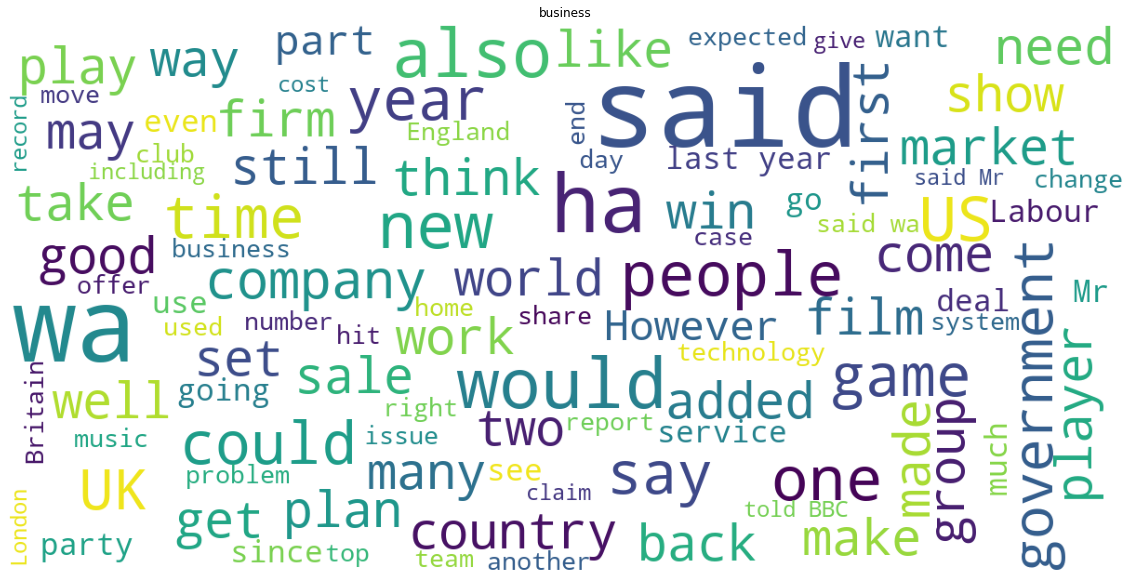

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


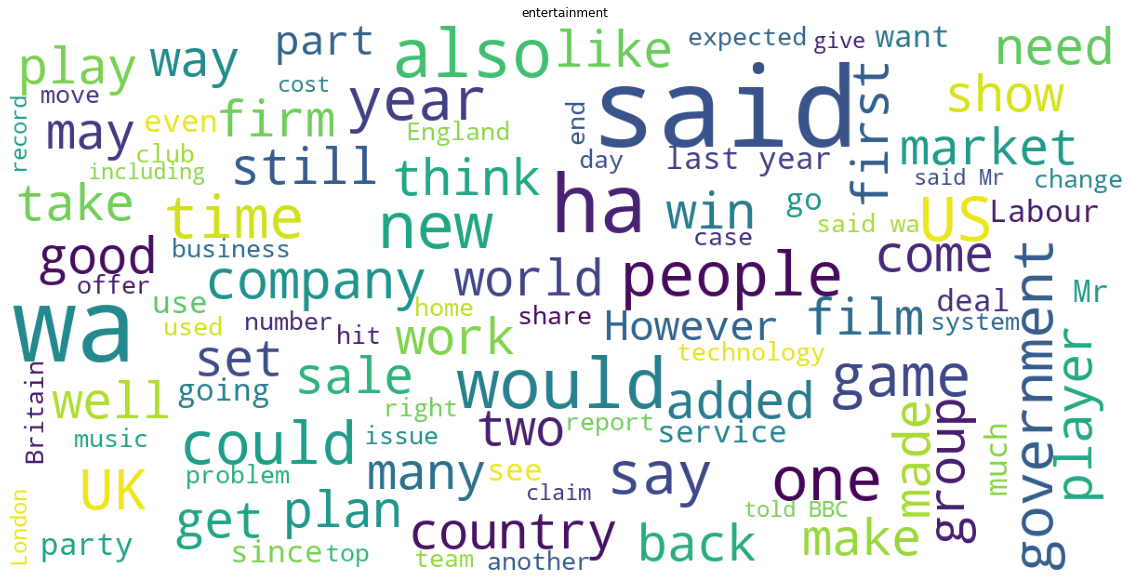

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


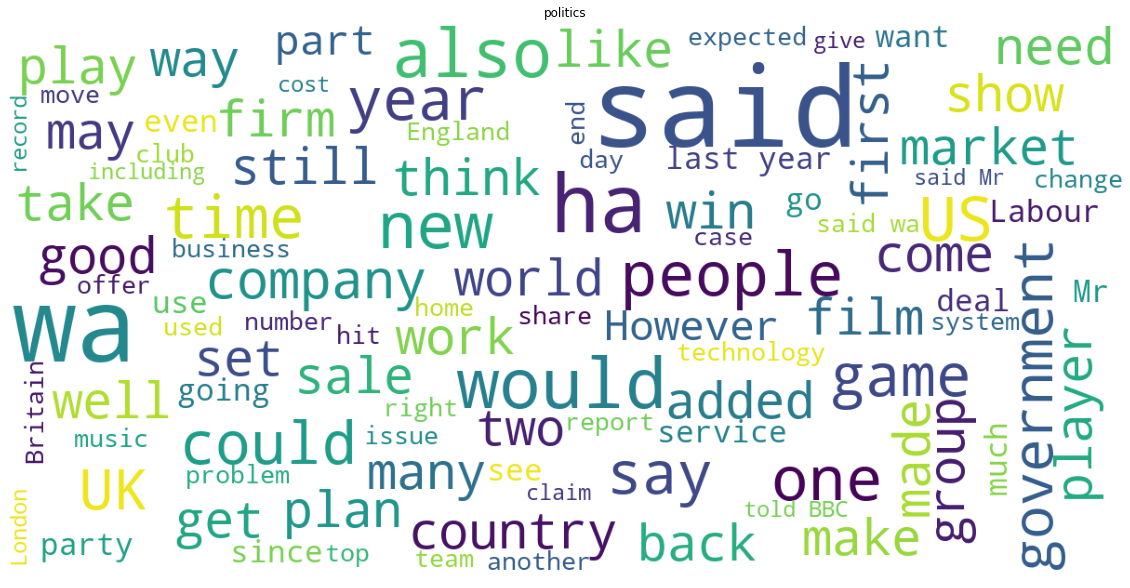

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


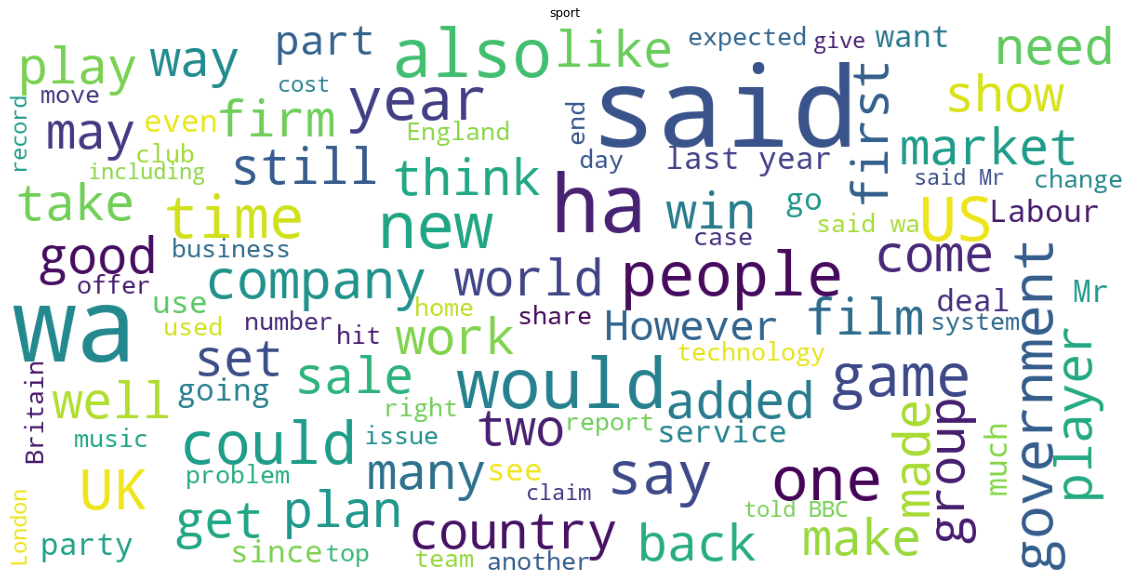

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


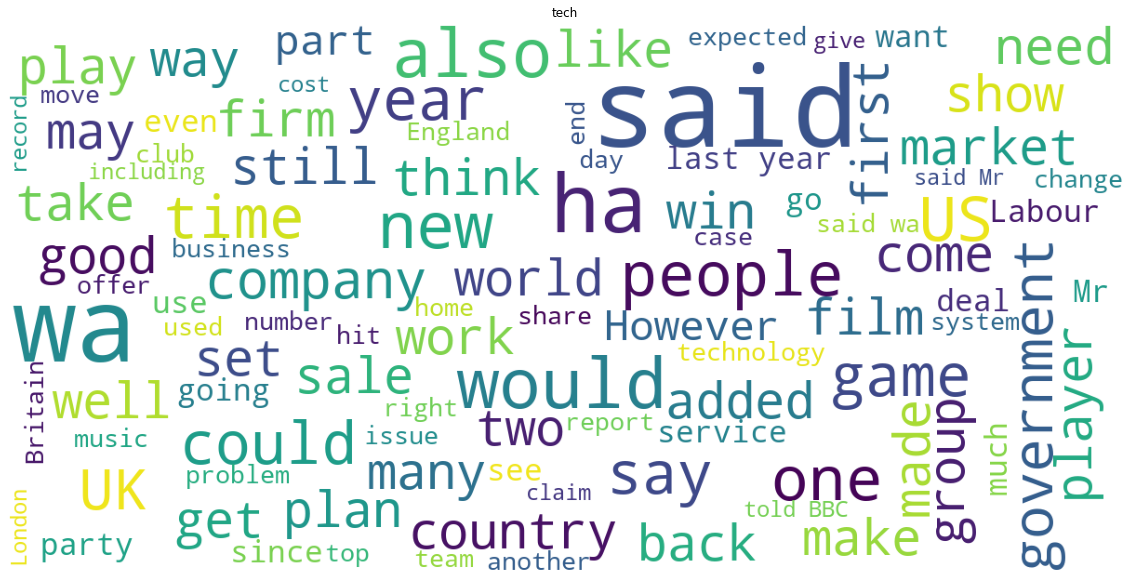

In [77]:
#create a word cloud for popular words in each topic
def word_cloud(data, topic):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    from matplotlib.offsetbox import AnnotationBbox, OffsetImage
    from PIL import Image
    import nltk
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer
    from wordcloud import WordCloud
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    wordcloud = WordCloud(background_color="white", max_words=100, stopwords=stop, max_font_size=40,
                          scale=3, random_state=1).generate(' '.join([i for i in data['text'] if i not in stop]))
    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title(topic)
    plt.show()

word_cloud(df, 'business')
word_cloud(df, 'entertainment')
word_cloud(df, 'politics')
word_cloud(df, 'sport')
word_cloud(df, 'tech')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


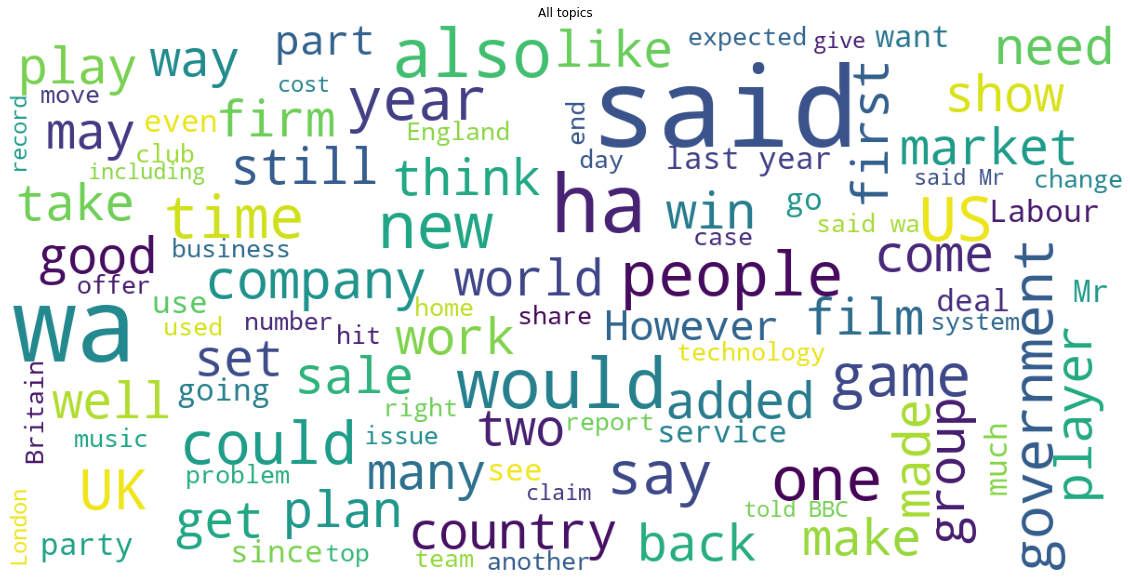

In [78]:
#create a word cloud for popular words in all topics
def word_cloud_all(data):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    from matplotlib.offsetbox import AnnotationBbox, OffsetImage
    from PIL import Image
    import nltk
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer
    from wordcloud import WordCloud
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    wordcloud = WordCloud(background_color="white", max_words=100, stopwords=stop, max_font_size=40,
                          scale=3, random_state=1).generate(' '.join([i for i in data['text'] if i not in stop]))
    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.title('All topics')
    plt.show()

word_cloud_all(df)


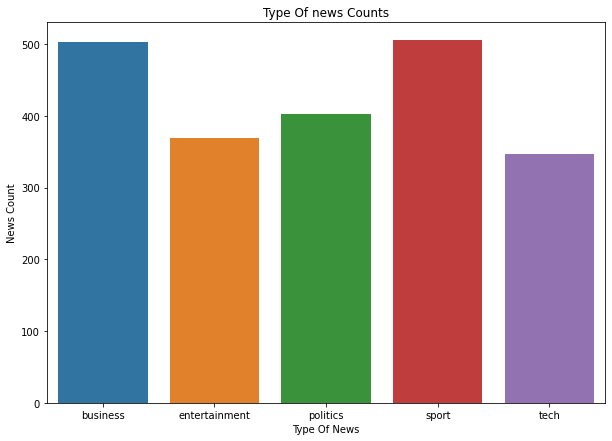

In [79]:
#set figure size
plt.rcParams['figure.figsize'] = [10, 7]

#create a countplot for type in df
sns.countplot(x='type', data=df)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")
plt.show()



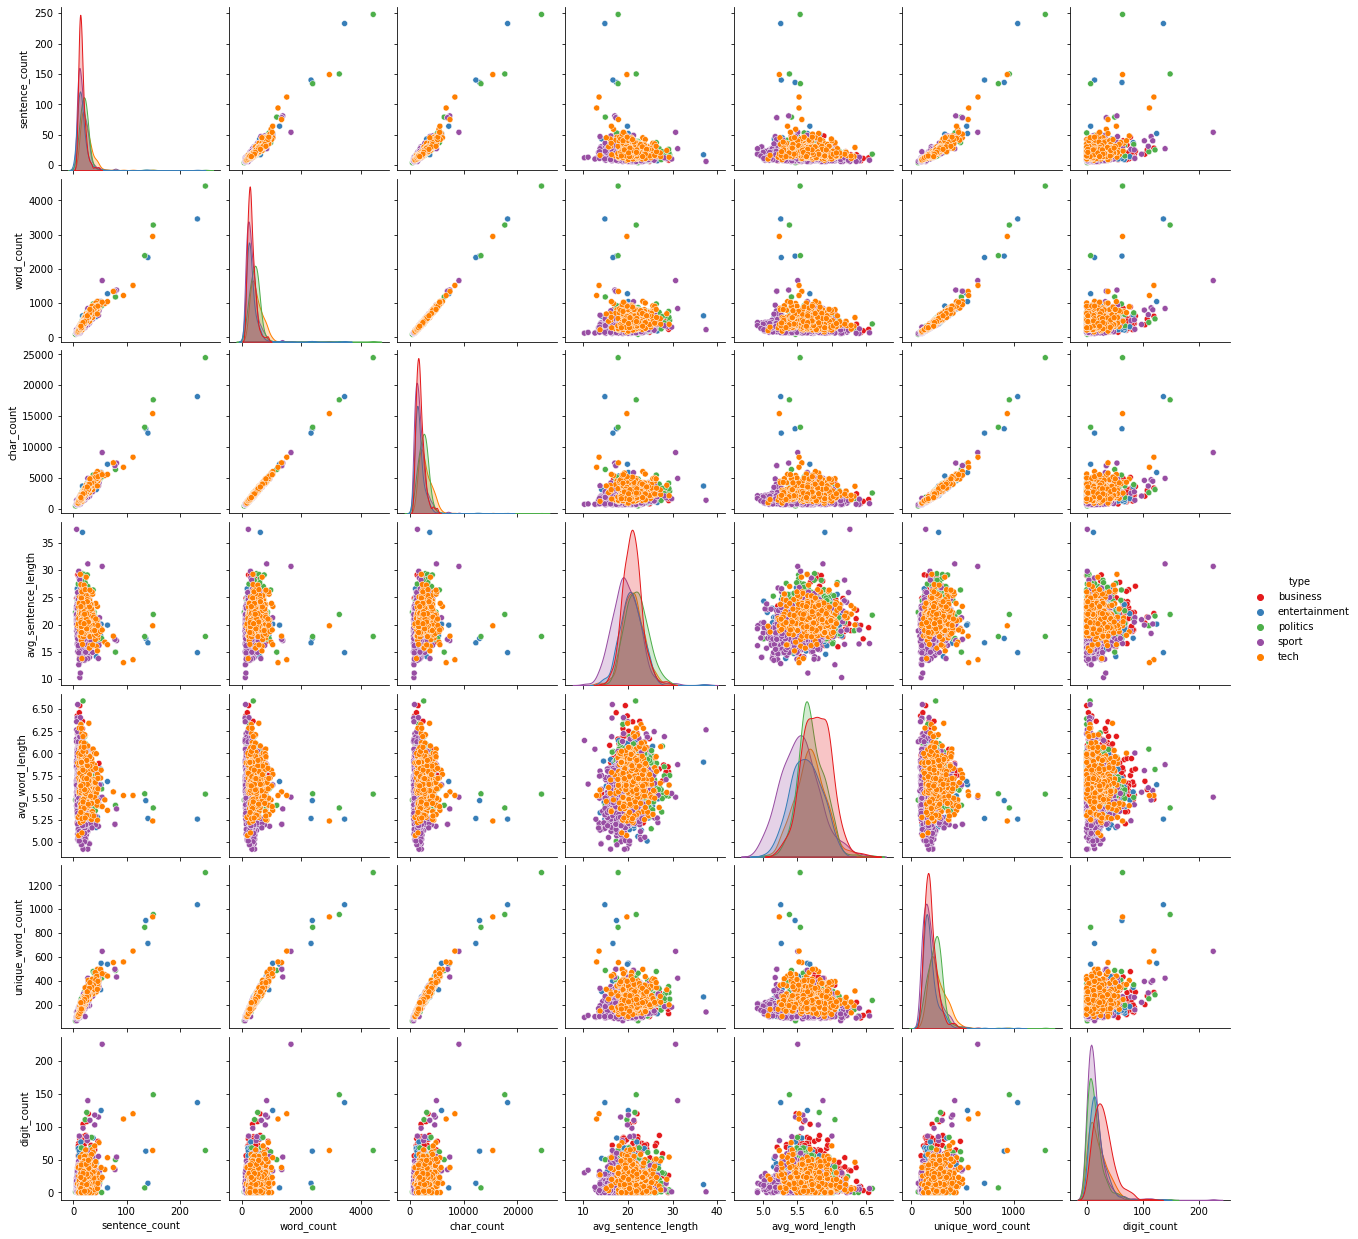

In [80]:
#create pairplot for all the features
sns.pairplot(df, hue='type', palette='Set1')
plt.show()

In [81]:
df.head()

,text,type,sentence_count,word_count,char_count,avg_sentence_length,avg_word_length,unique_word_count,digit_count
0,UK economy end year with spurt The UK economy ...,business,20,468,2702,23.400000,5.773504,249,41
1,China now top trader with Japan China overtook...,business,13,247,1394,19.000000,5.643725,137,84
2,Tsunami slows Sri Lankas growth Sri Lankas pre...,business,25,482,2885,19.280000,5.985477,273,28
3,Millions go missing at China bank Two senior o...,business,24,479,2874,19.958333,6.000000,275,28
4,Lacroix label bought by US firm Luxury good gr...,business,7,149,849,21.285714,5.697987,95,10


Topic Modelling

hierarchical clustering

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [83]:
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2)

dtm=tfidf.fit_transform(df['text'])

dtm.shape


(2127, 17283)

In [84]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [85]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


X = dtm.toarray()

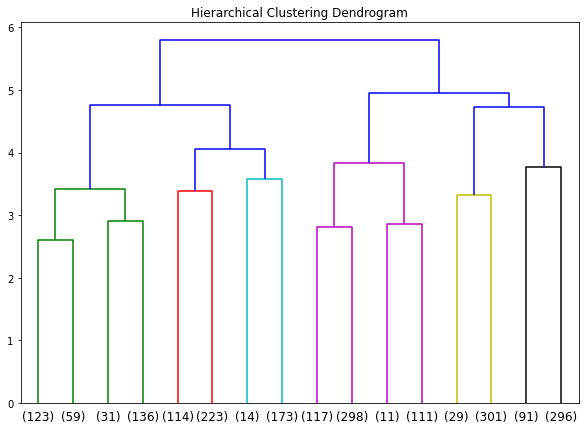

In [86]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
#plt.xlabel("Number of points in node")
plt.show()

From the above dendogram we can see that, we have successfully got 6 different clusters.

In [87]:
clustering = AgglomerativeClustering(n_clusters=6).fit(X)
clustering
AgglomerativeClustering()

AgglomerativeClustering()

In [88]:
pd.Series(clustering.labels_).unique()

heirdf=pd.DataFrame(dtm)

In [89]:
heirdf.head()

,0
0,"(0, 16815)\t0.03305515296294277\n (0, 14114..."
1,"(0, 15509)\t0.05464150064017917\n (0, 79)\t..."
2,"(0, 13022)\t0.04925251951525254\n (0, 9492)..."
3,"(0, 11411)\t0.031074019341707955\n (0, 8569..."
4,"(0, 3947)\t0.05693212957204208\n (0, 14840)..."


Latent Dirichlet Allocation (LDA)

In [90]:
df.head()

,text,type,sentence_count,word_count,char_count,avg_sentence_length,avg_word_length,unique_word_count,digit_count
0,UK economy end year with spurt The UK economy ...,business,20,468,2702,23.400000,5.773504,249,41
1,China now top trader with Japan China overtook...,business,13,247,1394,19.000000,5.643725,137,84
2,Tsunami slows Sri Lankas growth Sri Lankas pre...,business,25,482,2885,19.280000,5.985477,273,28
3,Millions go missing at China bank Two senior o...,business,24,479,2874,19.958333,6.000000,275,28
4,Lacroix label bought by US firm Luxury good gr...,business,7,149,849,21.285714,5.697987,95,10


In [91]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [92]:
# Tokenizing the words.

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [93]:
text_list=df['text'].tolist()
print(text_list[1])
tokenized_texts = lemmatization(text_list)
print(tokenized_texts[1])

China now top trader with Japan China overtook the US to become Japans biggest trading partner in 2004 according to number released by Japans Finance Ministry on Wednesday China accounted for 201 of Japans trade in 2004 compared with 186 for the US In 2003 the US wa ahead with 205 and China came second with 192 The change highlight Chinas growing importance a an economic powerhouse In 2004 Japans import from and export to China and Hong Kong added up to 22201bn yen 2146bn£1145bn This is the highest figure for Japanese trade with China since record began in 1947 It compare with 204795bn yen in trade with the US Trade with the US during 2004 wa hurt by oneoff factor including a 13month ban on US beef import following the discovery of a cow infected with mad cow disease BSE in the US However economist predict China will become an even more important Japanese trading partner in the coming year On Tuesday figure showed Chinas economy grew by 95 in 2004 and expert say the overall growth pict

In [94]:
from gensim import corpora

dictionary = corpora.Dictionary(tokenized_texts)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_texts]

In [95]:
# Creating the object for LDA model using gensim library
import gensim
from gensim import models
LDA = gensim.models.ldamodel.LdaModel

In [96]:
# Build LDA model
# Taking Number of topics=10
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50,iterations=100)

In [100]:
len(doc_term_matrix)

2127

In [101]:
# Print 10 topics with the weightage of words.
lda_model.print_topics()

[(0,
  '0.028*"technology" + 0.027*"tv" + 0.022*"broadband" + 0.016*"people" + 0.015*"content" + 0.014*"digital" + 0.013*"video" + 0.013*"music" + 0.012*"more" + 0.011*"player"'),
 (1,
  '0.010*"case" + 0.010*"human" + 0.009*"action" + 0.009*"child" + 0.008*"court" + 0.007*"school" + 0.007*"right" + 0.007*"man" + 0.007*"charge" + 0.007*"drug"'),
 (2,
  '0.043*"machine" + 0.024*"email" + 0.022*"gadget" + 0.016*"list" + 0.013*"first" + 0.013*"developer" + 0.012*"computer" + 0.011*"top" + 0.010*"pc" + 0.009*"mail"'),
 (3,
  '0.021*"government" + 0.016*"election" + 0.014*"people" + 0.012*"party" + 0.010*"tax" + 0.009*"plan" + 0.009*"country" + 0.009*"minister" + 0.008*"issue" + 0.008*"public"'),
 (4,
  '0.023*"year" + 0.019*"company" + 0.015*"firm" + 0.014*"market" + 0.010*"price" + 0.010*"sale" + 0.009*"business" + 0.009*"month" + 0.009*"share" + 0.009*"growth"'),
 (5,
  '0.016*"good" + 0.016*"player" + 0.014*"first" + 0.013*"time" + 0.012*"game" + 0.012*"year" + 0.011*"team" + 0.011*"las

In [102]:
# Visualize the topics
import pyLDAvis
from pyLDAvis import gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.067372  0.140437       1        1  19.630649
4      0.071202  0.125450       2        1  17.010024
5     -0.083417 -0.010922       3        1  14.527872
9     -0.054078 -0.044236       4        1  13.249441
1     -0.283190  0.042077       5        1   8.158905
7      0.134423  0.014548       6        1   7.535945
8      0.038570  0.097654       7        1   6.420447
6      0.097776  0.012037       8        1   5.659296
0      0.194748 -0.066164       9        1   5.220915
2     -0.048662 -0.310881      10        1   2.586507, topic_info=            Term         Freq        Total Category  logprob  loglift
2120        game  1434.000000  1434.000000  Default  30.0000  30.0000
1834        film   790.000000   790.000000  Default  29.0000  29.0000
206       people  1686.000000  1686.000000  Default  28.0000  28.0000
180   government  1017.000000  1017.000000  Default  27.0000  27.0000
1840          tv   485.000000   485.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
8        company    32.971433  1039.439224  Topic10  -5.1704   0.2041
377        phone    29.144694   513.427308  Topic10  -5.2938   0.7860
131       number    29.129608   757.046637  Topic10  -5.2943   0.3972
196         many    28.401147   797.664238  Topic10  -5.3196   0.3196
714        thing    24.517327   399.583584  Topic10  -5.4667   0.8638

[682 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
10973      8  0.971629      3d
148        1  0.170948  action
148        4  0.212390  action
148        5  0.442912  action
148        7  0.067343  action
...      ...       ...     ...
106        6  0.028816    year
106        7  0.043816    year
106        8  0.041052    year
106        9  0.051316    year
106       10  0.005526    year

[1460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 6, 10, 2, 8, 9, 7, 1, 3])

From the above we can see that, we getting maximum overlap between the different topics when number of topics is 10.

So, we need to optimise our model to reduce the overlap between the topics.

In [103]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.433424175781609

Coherence Score:  0.4387502462653378


Model having coherence score close to 1 is the best model for the topic modelling.



In [104]:
import pyLDAvis
import pyLDAvis.gensim 
import gensim

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

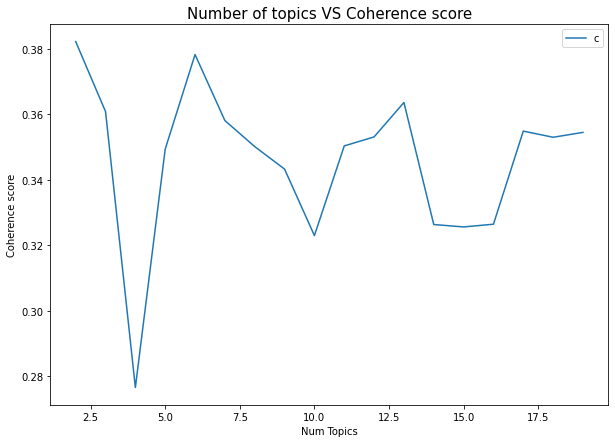

In [105]:
# Min number of topics=2
# Max number of topics=20

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_texts, start=2, limit=20, step=1)

# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title('Number of topics VS Coherence score',size=15)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [106]:
# Print the coherence scores for various 
for m, cv in zip(x, coherence_values):
    print("Number Of Topics =", m, " has Coherence Value of", round(cv, 4))

Number Of Topics = 2  has Coherence Value of 0.3822
Number Of Topics = 3  has Coherence Value of 0.3609
Number Of Topics = 4  has Coherence Value of 0.2766
Number Of Topics = 5  has Coherence Value of 0.3494
Number Of Topics = 6  has Coherence Value of 0.3782
Number Of Topics = 7  has Coherence Value of 0.3581
Number Of Topics = 8  has Coherence Value of 0.3502
Number Of Topics = 9  has Coherence Value of 0.3433
Number Of Topics = 10  has Coherence Value of 0.323
Number Of Topics = 11  has Coherence Value of 0.3504
Number Of Topics = 12  has Coherence Value of 0.3531
Number Of Topics = 13  has Coherence Value of 0.3636
Number Of Topics = 14  has Coherence Value of 0.3264
Number Of Topics = 15  has Coherence Value of 0.3256
Number Of Topics = 16  has Coherence Value of 0.3265
Number Of Topics = 17  has Coherence Value of 0.3549
Number Of Topics = 18  has Coherence Value of 0.353
Number Of Topics = 19  has Coherence Value of 0.3545


From the above we can see that, the coherence score is high when the number of topics is 2.

In [115]:
# Select the model and print the topics.
# Taking number of topics=5.
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.012*"year" + 0.008*"people" + 0.007*"game" + 0.006*"more" + 0.006*"blog" + 0.006*"good" + 0.005*"blogger" + 0.005*"company" + 0.005*"firm" + 0.005*"world"'),
 (1,
  '0.018*"game" + 0.011*"people" + 0.010*"phone" + 0.009*"new" + 0.009*"mobile" + 0.009*"year" + 0.008*"technology" + 0.007*"more" + 0.006*"computer" + 0.006*"other"'),
 (2,
  '0.014*"people" + 0.010*"site" + 0.010*"year" + 0.010*"net" + 0.009*"tv" + 0.007*"other" + 0.007*"more" + 0.007*"blog" + 0.006*"new" + 0.006*"many"')]

In [116]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.049086  0.034340       1        1  62.339153
1      0.070756  0.010186       2        1  19.369439
2     -0.021670 -0.044526       3        1  18.291408, topic_info=            Term         Freq        Total Category  logprob  loglift
2120        game  1947.000000  1947.000000  Default  30.0000  30.0000
206       people  2150.000000  2150.000000  Default  29.0000  29.0000
450         site   915.000000   915.000000  Default  28.0000  28.0000
377        phone   821.000000   821.000000  Default  27.0000  27.0000
623          net   734.000000   734.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
887         news   109.722781   322.198909   Topic3  -5.9242   0.6215
1947  technology   157.142718   968.517126   Topic3  -5.5650  -0.1199
37          good   156.668652  1153.863060   Topic3  -5.5681  -0.2980
462          way   150.742355  1003.104777   Topic3  -5.6066  -0.1965
2120        game   153.817556  1947.326517   Topic3  -5.5864  -0.8397

[285 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
11187      1  0.955792  adapter
11187      2  0.035400  adapter
11187      3  0.017700  adapter
12219      1  0.138289  allmale
12219      2  0.829736  allmale
...      ...       ...      ...
106        1  0.680693     year
106        2  0.152583     year
106        3  0.166901     year
12432      1  0.148697      zip
12432      3  0.892182      zip

[583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])